In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

<Axes: >

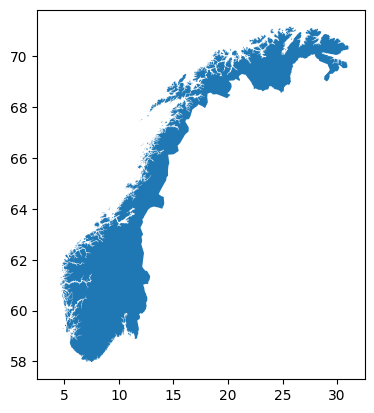

In [3]:
# Reading the world shapefile 
norway = gpd.read_file(r'gadm41_NOR_shp/gadm41_NOR_0.shp') 
  
norway
norway.plot() 

In [10]:
filtered_clean_final_data = pd.read_csv('filtered_clean_final_data.csv')
filtered_clean_final_data

/tmp/ipykernel_5375/1711987206.py:1: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  filtered_clean_final_data = pd.read_csv('filtered_clean_final_data.csv')


,gbifID,taxonRank,family,species,verbatimScientificNameAuthorship,decimalLongitude,decimalLatitude,coordinateUncertaintyInMeters,elevation,elevationAccuracy,year,countryCode,locality,basisOfRecord,institutionCode,recordedBy,issue,geometry
0,2.575367e+09,SPECIES,Brassicaceae,Arabis alpina,NaN,9.551944,62.288889,NaN,1048.0,NaN,1993,NO,"Sör-Tröndelag, Oppdal, 3 km SE of Kongsvoll, s...",PRESERVED_SPECIMEN,ZT,Örjan Eric Gustaf Nilsson;Walter Herbert Hube...,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (9.551944 62.288889)
1,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,10.804000,60.893200,NaN,NaN,NaN,2001,NO,Ringsaker: Kinnli l. (223/1)/Leine . (225/1) K...,OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (10.804 60.8932)
2,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,10.256800,59.813800,NaN,NaN,NaN,1992,NO,"Tranby: Lyngskrysset, veikant",OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (10.2568 59.8138)
3,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,11.749100,59.343200,NaN,NaN,NaN,2000,NO,Gysbu kerugras,OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (11.7491 59.3432)
4,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,11.644300,59.464800,NaN,NaN,NaN,2001,NO,SV f rje (3Q-flate 2130),OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (11.6443 59.4648)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3011724,2.984830e+09,SPECIES,Fabaceae,Lupinus polyphyllus,NaN,18.606141,69.141753,50.0,NaN,NaN,2019,NO,Gulveisveien 2,HUMAN_OBSERVATION,Ecofact,Eirik Aasmo Finne,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (18.606141 69.141753)
3011725,2.984830e+09,SPECIES,Sapindaceae,Acer pseudoplatanus,NaN,5.689372,60.006034,25.0,NaN,NaN,2019,NO,Tveit vest 5,HUMAN_OBSERVATION,Ecofact,Julie Brastein Halvorsen,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (5.689372 60.006034)
3011726,2.984830e+09,SPECIES,Oleaceae,Fraxinus excelsior,NaN,5.236414,60.273174,5.0,NaN,NaN,2019,NO,Myntevikvegen-Espelandvegen 1,HUMAN_OBSERVATION,Ecofact,Bente Sved Skottvoll,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (5.236414 60.273174)
3011727,2.984830e+09,SPECIES,Tamaricaceae,Myricaria germanica,NaN,19.121222,68.999122,5.0,NaN,NaN,2019,NO,Øya 1,HUMAN_OBSERVATION,Ecofact,Martha Karijord,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (19.121222 68.999122)


In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, box

# Load the Norway shapefile
norway = gpd.read_file("gadm41_NOR_shp/gadm41_NOR_0.shp").to_crs(epsg=32633) 

# Convert occurrences to a GeoDataFrame
filtered_clean_final_data["geometry"] = gpd.points_from_xy(
    filtered_clean_final_data["decimalLongitude"], 
    filtered_clean_final_data["decimalLatitude"]
)
gdf = gpd.GeoDataFrame(filtered_clean_final_data, geometry="geometry", crs="EPSG:4326")

# Reproject occurrences to UTM zone 33N for metric calculations
gdf = gdf.to_crs(norway.crs)

# Function to create a 1km x 1km grid
def create_grid(bounds, cell_size=1000):
    xmin, ymin, xmax, ymax = bounds
    grid_cells = []
    
    for x in range(int(xmin), int(xmax), cell_size):
        for y in range(int(ymin), int(ymax), cell_size):
            grid_cells.append(box(x, y, x + cell_size, y + cell_size))
    
    return gpd.GeoDataFrame(geometry=grid_cells, crs=norway.crs)

# Create the grid
grid = create_grid(norway.total_bounds)

# Ensure the grid is in a projected CRS (UTM zone 33N)
grid = grid.to_crs(epsg=32633)  # Convert grid to UTM before centroid calculation

# Compute centroids in projected CRS
grid["centroid"] = grid.geometry.centroid  

# Convert centroids back to WGS84 (EPSG:4326) for plotting
grid = grid.set_geometry("centroid").to_crs(epsg=4326)

# Extract latitude and longitude
grid["latitude"] = grid.centroid.y
grid["longitude"] = grid.centroid.x

# Restore original grid geometry
grid = grid.set_geometry("geometry") 

# Spatial join: Assign each occurrence to a grid cell
gdf = gdf.sjoin(grid, how="left")
gdf = gdf.rename(columns={"index_right": "grid_index"})
# Group by grid cell and year, aggregating species into lists
result = gdf.groupby(["grid_index", "year"])["species"].apply(lambda x: list(set(x))).reset_index()

# Filter out assemblages with fewer than 5 species
result = result[result["species"].apply(lambda x: len(x) >= 5)]

# Merge with grid centroids (ensure to merge on 'index_right' properly)
result = result.merge(grid[["longitude", "latitude"]], left_on="grid_index", right_index=True, how="left")

# View final result
print(result.head())




DataSourceError: gadm41_NOR_shp/gadm41_NOR_0.shp: No such file or directory

In [58]:
#gdf.to_csv('csv/occurrences_by_grid_with_centroids.csv')
gdf

,gbifID,taxonRank,family,species,verbatimScientificNameAuthorship,decimalLongitude,decimalLatitude,coordinateUncertaintyInMeters,elevation,elevationAccuracy,...,locality,basisOfRecord,institutionCode,recordedBy,issue,geometry,grid_index,centroid,latitude,longitude
0,2.575367e+09,SPECIES,Brassicaceae,Arabis alpina,NaN,9.551944,62.288889,NaN,1048.0,NaN,...,"Sör-Tröndelag, Oppdal, 3 km SE of Kongsvoll, s...",PRESERVED_SPECIMEN,ZT,Örjan Eric Gustaf Nilsson;Walter Herbert Hube...,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (217593.225 6918262.769),494321,POINT (9.56094 62.28561),62.285609,9.560940
1,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,10.804000,60.893200,NaN,NaN,NaN,...,Ringsaker: Kinnli l. (223/1)/Leine . (225/1) K...,OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (272401.552 6758177.896),574729,POINT (10.79751 60.89013),60.890130,10.797511
2,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,10.256800,59.813800,NaN,NaN,NaN,...,"Tranby: Lyngskrysset, veikant",OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (234100.398 6640196.713),517915,POINT (10.25594 59.81073),59.810731,10.255944
3,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,11.749100,59.343200,NaN,NaN,NaN,...,Gysbu kerugras,OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (315137.892 6582781.853),638710,POINT (11.7471 59.34384),59.343844,11.747105
4,1.300744e+09,SUBSPECIES,Brassicaceae,Brassica rapa,NaN,11.644300,59.464800,NaN,NaN,NaN,...,SV f rje (3Q-flate 2130),OCCURRENCE,BHAM_Maxted,NaN,GEODETIC_DATUM_ASSUMED_WGS84;CONTINENT_DERIVED...,POINT (309864.552 6596607.462),631264,POINT (11.64696 59.46713),59.467129,11.646955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3011724,2.984830e+09,SPECIES,Fabaceae,Lupinus polyphyllus,NaN,18.606141,69.141753,50.0,NaN,NaN,...,Gulveisveien 2,HUMAN_OBSERVATION,Ecofact,Eirik Aasmo Finne,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (643224.998 7674381.952),1129178,POINT (18.6019 69.14613),69.146127,18.601898
3011725,2.984830e+09,SPECIES,Sapindaceae,Acer pseudoplatanus,NaN,5.689372,60.006034,25.0,NaN,NaN,...,Tveit vest 5,HUMAN_OBSERVATION,Ecofact,Julie Brastein Halvorsen,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (-18081.038 6688661.091),141980,POINT (5.6908 60.00792),60.007925,5.690804
3011726,2.984830e+09,SPECIES,Oleaceae,Fraxinus excelsior,NaN,5.236414,60.273174,5.0,NaN,NaN,...,Myntevikvegen-Espelandvegen 1,HUMAN_OBSERVATION,Ecofact,Bente Sved Skottvoll,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (-38757.415 6721842.16),110681,POINT (5.23255 60.27304),60.273039,5.232546
3011727,2.984830e+09,SPECIES,Tamaricaceae,Myricaria germanica,NaN,19.121222,68.999122,5.0,NaN,NaN,...,Øya 1,HUMAN_OBSERVATION,Ecofact,Martha Karijord,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,POINT (664726.012 7659797.999),1161987,POINT (19.12886 68.99949),68.999486,19.128855


In [57]:
# Save or print results
result.to_csv("csv/assemblages_aggregated_by_grid_with_centroids.csv", index=False)

result

,grid_index,year,species,longitude,latitude
2,79228,2020,"[Lonicera periclymenum, Tripolium pannonicum, ...",5.180633,59.174643
8,79231,2011,"[Angelica archangelica, Dactylorhiza majalis, ...",5.172939,59.201189
9,79231,2012,"[Carex distans, Euphrasia foulaensis, Carex ot...",5.172939,59.201189
10,79231,2014,"[Lysimachia europaea, Ficaria verna, Juncus ar...",5.172939,59.201189
11,79231,2015,"[Tripolium pannonicum, Centaurium littorale, P...",5.172939,59.201189
...,...,...,...,...,...
189967,1818627,2017,"[Luzula spicata, Antennaria dioica, Cochlearia...",30.835603,69.774990
189973,1820117,1994,"[Honckenya peploides, Alnus incana, Epilobium ...",30.847255,69.755439
189978,1821608,1994,"[Taraxacum spectabile, Astragalus norvegicus, ...",30.865522,69.744514
189983,1823096,2019,"[Lysimachia europaea, Chamaenerion angustifoli...",30.863871,69.707711


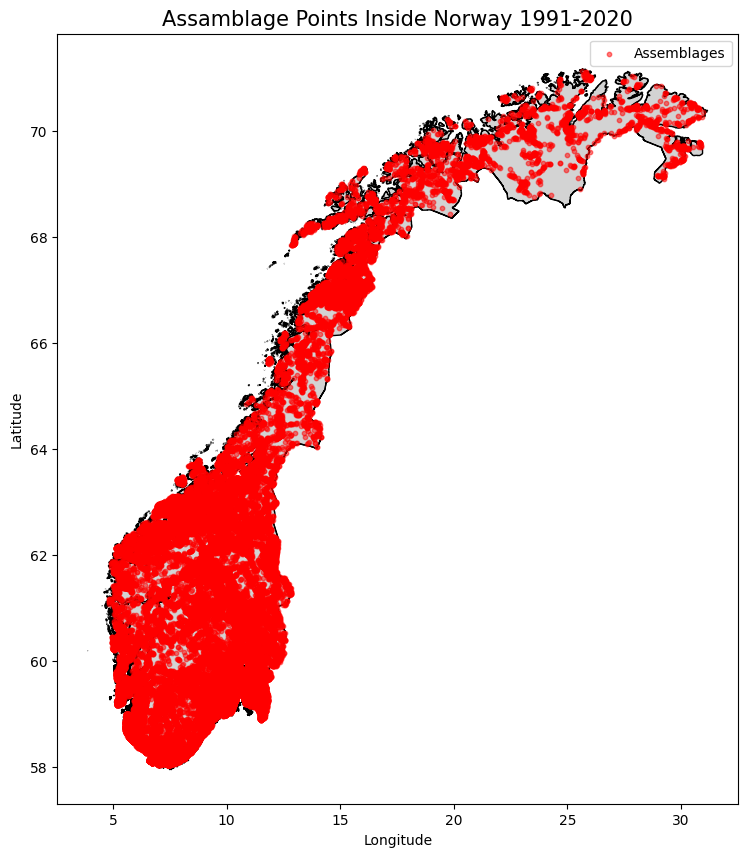

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
result = pd.read_csv("GBIF/csv/assemblages_aggregated_by_grid_with_centroids.csv")

# Load the shapefile of Norway's boundaries (assuming you have this shapefile)
norway = gpd.read_file("GBIF/gadm41_NOR_shp/gadm41_NOR_0.shp").to_crs(epsg=4326)  # Make sure it's in EPSG:4326 for plotting

# Step 2: Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Norway boundary
norway.plot(ax=ax, color="lightgray", edgecolor="black")

# Assuming 'result' DataFrame has columns 'longitude' and 'latitude' (from the grid centroids)
result_geo_df = gpd.GeoDataFrame(
    result, 
    geometry=gpd.points_from_xy(result.longitude, result.latitude),
    crs="EPSG:4326"  # Ensure the correct CRS
)

# Plot the filtered points inside Norway
result_geo_df.plot(ax=ax, markersize=10, color='red', alpha=0.5, label="Assemblages")

# Customize plot
ax.set_title("Assamblage Points Inside Norway 1991-2020", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show the plot
plt.show()
